# Term1 Sprint1 授業課題 
## コーディング課題：機械学習フロー

Kaggleの Home Credit Default Risk コンペティションを活用し、実データに近いものに対し、自ら課題を設定して分析する練習を行う。  
[Home Credit Default Riskコンペティション](https://www.kaggle.com/c/home-credit-default-risk "Home Credit Default Riskコンペティション")

## 1. クロスバリデーション
事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行っていた。しかし、分割の仕方により精度は変化する。  
実践的にはクロスバリデーション を行う。  
具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法。複数回の分割を行う関数はscikit-learnにKFoldとして用意されている。
[sklearn.model_selection.KFold — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold "sklearn.model_selection.KFold — scikit-learn 0.20.2 documentation")

## 2. グリッドサーチ
パラメータを探索するためにグリッドサーチと呼ばれる総当たり的手法が一般的に利用される。グリッドサーチをパイプラインの中に組み込む。

## 3. Kernelからの調査
KaggleのKernelから自身にはなかったアイデアを見つけ出し、列挙する。そして、効果があると考えられるものを検証する。

## 4. 高い汎化性能のモデル
これまで学んだことを用いながら汎化性能の高いモデルを作成する。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すことも意識する。

## 以下はTerm0の内容

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!cd gdrive

In [0]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import metrics



pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 500)

In [0]:
# train.csvの読み込み
df_train = pd.read_csv("./gdrive/My Drive/Colab Notebooks/application_train.csv")

In [0]:
df_test = pd.read_csv("./gdrive/My Drive/Colab Notebooks/application_test.csv")

In [6]:
#学習データの情報表示
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
#特徴量の要約統計量の表示
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [8]:
# 各特徴量のデータ総数
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# 欠損値があるデータをカウント
Total = df_train.isnull().sum()
# 欠損値の割合を算出
missing_rate = Total / len(df_train)

#　テーブルにカウントした欠損値と割合を格納
missing_table = pd.DataFrame({
    'Total': Total,
    'missing_rate': missing_rate
})

#欠損値の割合が大きい順にソートする
missing_table.sort_values(by='missing_rate', ascending=False)

,Total,missing_rate
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
FONDKAPREMONT_MODE,210295,0.683862
LIVINGAPARTMENTS_MODE,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550
LIVINGAPARTMENTS_MEDI,210199,0.683550


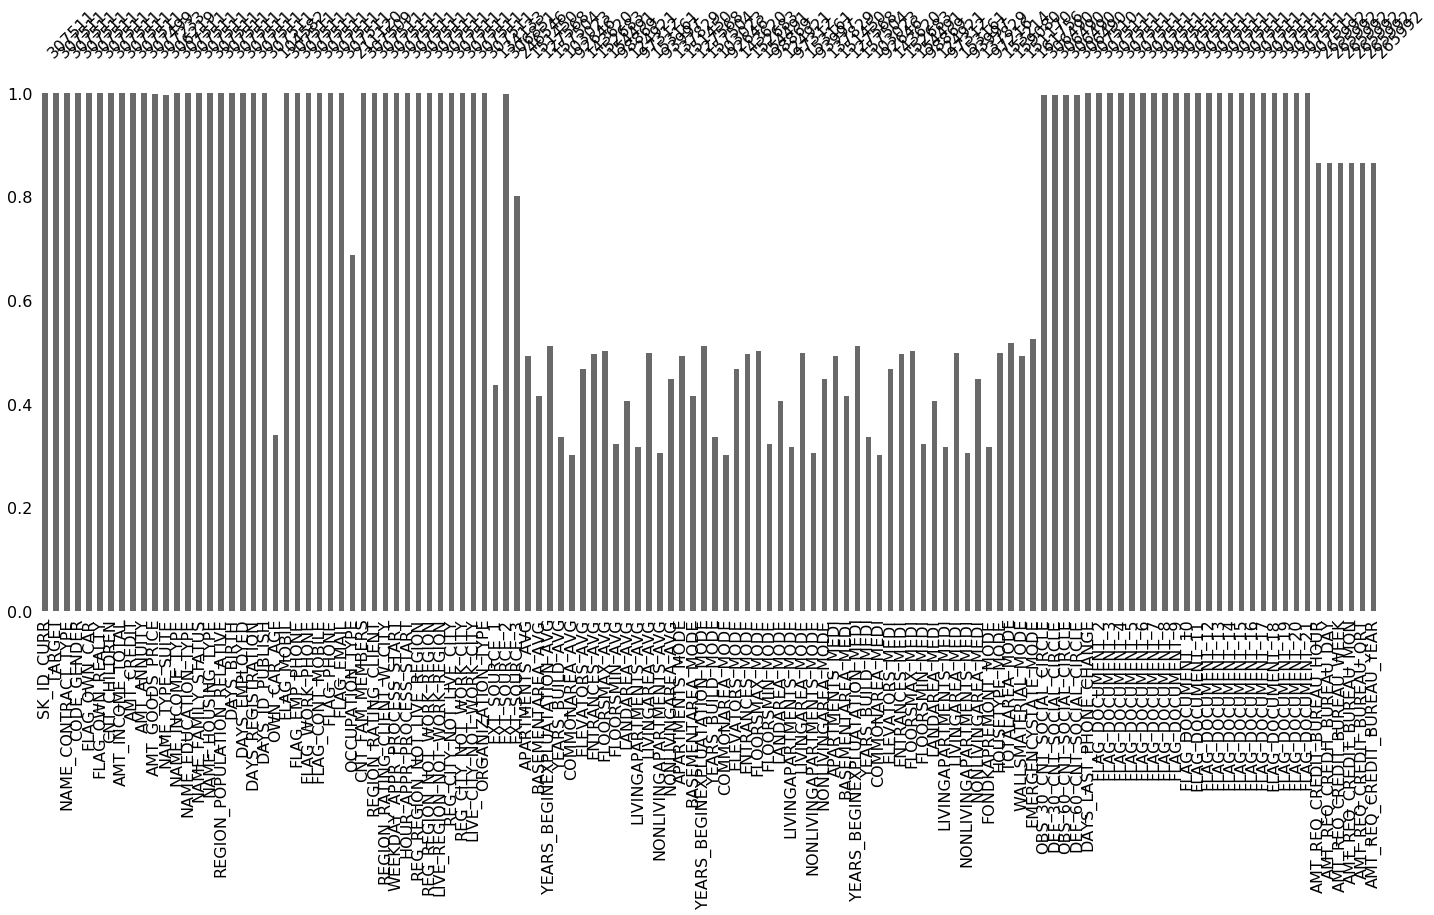

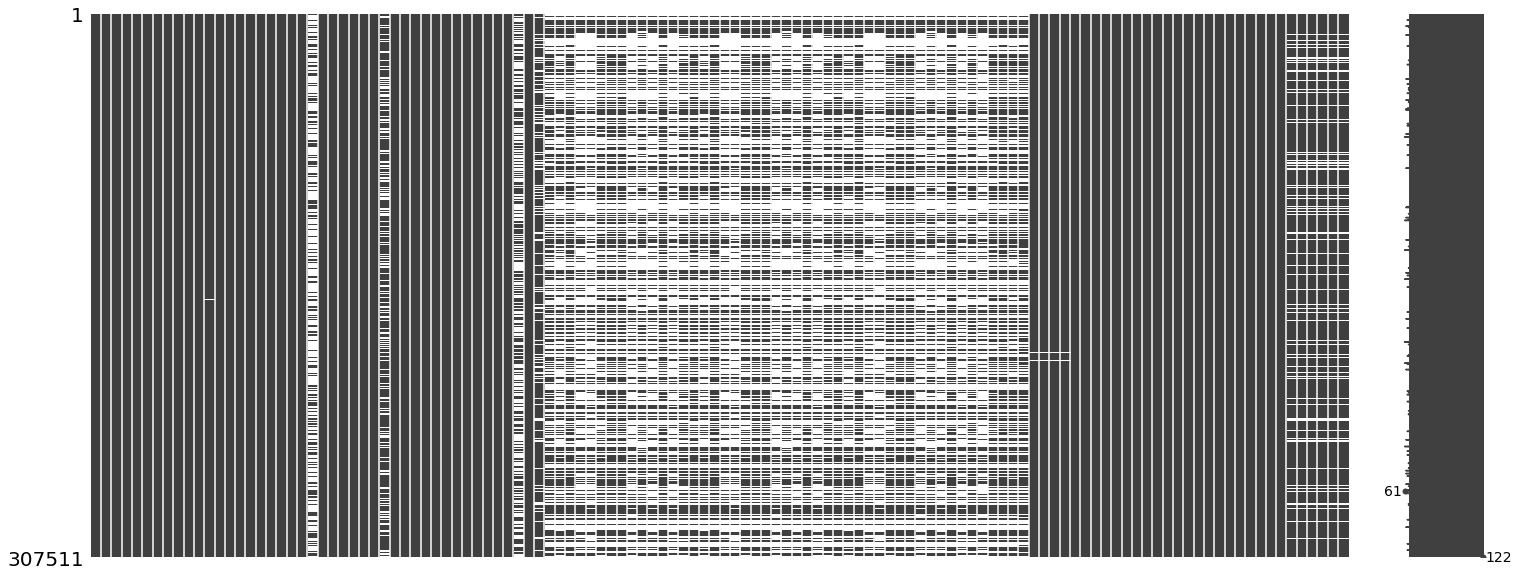

In [10]:
#missingnoモジュールのインポート
import missingno as msno

#欠損値の有無をバーとして表示
#バーが1.0に満たない特徴量に欠損値が発生していると確認できる
msno.bar(df_train)
plt.show()
msno.matrix(df_train)
plt.show()

In [11]:
df_train.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [12]:
# カテゴリ変数において、各変数の取りうる値の数を計算
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
# 上記で2個はlabel-encoding

def df_labelencoder(df):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in df:
        if df[col].dtype == 'object':
            if len(list(df[col].unique())) <= 2:
                le.fit(df[col])
                df[col] = le.transform(df[col])

df_labelencoder(df_train)
df_labelencoder(df_test)

# 3個以上はone-hot-encoding
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (307511, 243)
df_test shape:  (48744, 238)


In [14]:
# 訓練データとテストデータの両方にある列のみ残し、訓練データには目的変数を残す
train_labels = df_train['TARGET']
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
df_train['TARGET'] = train_labels

print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (307511, 238)
df_test shape:  (48744, 237)


In [15]:
# 目的変数との相関係数をみる
correlations = df_train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                        -0.178919
EXT_SOURCE_2                                        -0.160472
EXT_SOURCE_1                                        -0.155317
NAME_EDUCATION_TYPE_Higher education                -0.056593
NAME_INCOME_TYPE_Pensioner                          -0.046209
ORGANIZATION_TYPE_XNA                               -0.045987
DAYS_EMPLOYED                                       -0.044932
FLOORSMAX_AVG                                       -0.044003
FLOORSMAX_MEDI                                      -0.043768
FLOORSMAX_MODE                                      -0.043226
EMERGENCYSTATE_MODE_No                              -0.042201
HOUSETYPE_MODE_block of flats                       -0.040594
AMT_GOODS_PRICE                                     -0.039645
REGION_POPULATION_RELATIVE                          -0.037227
ELEVATORS_AVG                                       -0.034199
ELEVATORS_MEDI                                      -0.033863
FLOORSMI

In [16]:
# まずは"DAYS_EMPLOYED"をみる
print("------DAYS_EMPLOYED------\n")
(df_train['DAYS_EMPLOYED']).describe()

------DAYS_EMPLOYED------



count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

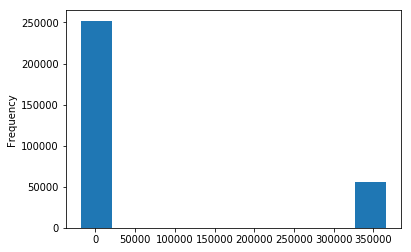

In [17]:
# DAYS_EMPLOYEDに外れ値があり、分布に異常あり
df_train['DAYS_EMPLOYED'].plot.hist()

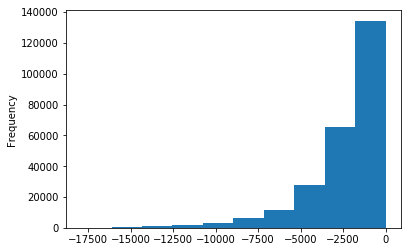

In [18]:
# 外れ値のフラグ列を作る
df_train['DAYS_EMPLOYED_OUTLIERS'] = df_train["DAYS_EMPLOYED"] == 365243

# 外れ値はnanで置換
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
df_train['DAYS_EMPLOYED'].plot.hist()

In [19]:
df_train["DAYS_EMPLOYED"].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [0]:
# テストデータにも同様の処理
df_test['DAYS_EMPLOYED_OUTLIERS'] = df_test["DAYS_EMPLOYED"] == 365243
df_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [21]:
# "DAYS_EMPLOYED_OUTLIERS"と相関のある特徴量をみる
correlations = df_train.corr()['DAYS_EMPLOYED_OUTLIERS'].sort_values()
correlations

FLAG_EMP_PHONE                                      -0.999868
DAYS_BIRTH                                          -0.619947
NAME_INCOME_TYPE_Working                            -0.484189
DAYS_ID_PUBLISH                                     -0.273633
NAME_INCOME_TYPE_Commercial associate               -0.258217
REG_CITY_NOT_WORK_CITY                              -0.256454
ORGANIZATION_TYPE_Business Entity Type 3            -0.249686
FLAG_DOCUMENT_3                                     -0.248508
CNT_CHILDREN                                        -0.240722
CNT_FAM_MEMBERS                                     -0.233981
FLAG_WORK_PHONE                                     -0.233834
LIVE_CITY_NOT_WORK_CITY                             -0.219234
OCCUPATION_TYPE_Laborers                            -0.219164
DAYS_REGISTRATION                                   -0.212417
ORGANIZATION_TYPE_Self-employed                     -0.177057
OCCUPATION_TYPE_Sales staff                         -0.159997
FLAG_OWN

"FLAG_EMP_PHONE"（会社用電話があったか）で極めて低値、"NAME_INCOME_TYPE_Pensioner"（年金受給者）で極めて高値。"DAYS_EMPLOYED_OUTLIERS"の人は無職の年金受給者（高齢者）とわかるが、上記より"TARGET"との相関はほぼないので、"DAYS_EMPLOYED"の欠損値は中央値で埋める。

In [0]:
df_train["DAYS_EMPLOYED"] = df_train["DAYS_EMPLOYED"].fillna(df_train["DAYS_EMPLOYED"].median())
df_test["DAYS_EMPLOYED"] = df_test["DAYS_EMPLOYED"].fillna(df_test["DAYS_EMPLOYED"].median())

In [23]:
# "DAYS_BIRTH"の欠損値はなし
df_train["DAYS_BIRTH"].isnull().sum() + df_test["DAYS_BIRTH"].isnull().sum()

0

In [0]:
# 理解しやすいように絶対値にしておく
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_test['DAYS_BIRTH'] = abs(df_test['DAYS_BIRTH'])

In [25]:
# EXT_SOURCEについて
df_train[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]].isnull().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [26]:
# EXT_SOURCEの欠損値の各列を新たに作り、相関のある特徴量をみる
df_train["EXT_SOURCE_1_OUTLIERS"] = df_train["EXT_SOURCE_1"].isnull()
df_train["EXT_SOURCE_2_OUTLIERS"] = df_train["EXT_SOURCE_2"].isnull()
df_train["EXT_SOURCE_3_OUTLIERS"] = df_train["EXT_SOURCE_3"].isnull()
correlations = df_train.corr()

# "EXT_SOURCE_1_OUTLIERS"と相関のある特徴量をみる
correlations["EXT_SOURCE_1_OUTLIERS"].sort_values()

FLAG_EMP_PHONE                                      -0.192703
FLAG_EMAIL                                          -0.147304
NAME_EDUCATION_TYPE_Higher education                -0.127746
DAYS_REGISTRATION                                   -0.123604
CNT_CHILDREN                                        -0.112907
CNT_FAM_MEMBERS                                     -0.095716
OCCUPATION_TYPE_Core staff                          -0.075247
OCCUPATION_TYPE_Accountants                         -0.075015
NAME_INCOME_TYPE_Commercial associate               -0.072582
NAME_INCOME_TYPE_Working                            -0.066443
ORGANIZATION_TYPE_Business Entity Type 3            -0.063547
OCCUPATION_TYPE_Managers                            -0.058928
AMT_ANNUITY                                         -0.057880
DAYS_ID_PUBLISH                                     -0.057243
EXT_SOURCE_2                                        -0.054732
NAME_EDUCATION_TYPE_Incomplete higher               -0.051819
FLAG_WOR

In [27]:
# "EXT_SOURCE_2_OUTLIERS"と相関のある特徴量をみる
correlations["EXT_SOURCE_2_OUTLIERS"].sort_values()

FLAG_MOBIL                                          -0.038883
AMT_GOODS_PRICE                                     -0.015856
AMT_CREDIT                                          -0.015127
AMT_ANNUITY                                         -0.014506
AMT_REQ_CREDIT_BUREAU_YEAR                          -0.011305
DAYS_REGISTRATION                                   -0.007439
AMT_REQ_CREDIT_BUREAU_QRT                           -0.007358
FLAG_EMP_PHONE                                      -0.006789
YEARS_BUILD_AVG                                     -0.006441
YEARS_BUILD_MEDI                                    -0.006424
YEARS_BUILD_MODE                                    -0.006100
FLAG_DOCUMENT_8                                     -0.005836
OCCUPATION_TYPE_Managers                            -0.005766
FLAG_OWN_CAR                                        -0.005706
NAME_HOUSING_TYPE_House / apartment                 -0.005478
NAME_FAMILY_STATUS_Married                          -0.004914
AMT_INCO

In [28]:
# "EXT_SOURCE_3_OUTLIERS"と相関のある特徴量をみる
correlations["EXT_SOURCE_3_OUTLIERS"].sort_values()

EXT_SOURCE_1                                        -0.060414
NAME_FAMILY_STATUS_Married                          -0.048551
AMT_CREDIT                                          -0.044526
EXT_SOURCE_2                                        -0.044220
AMT_GOODS_PRICE                                     -0.044118
DAYS_BIRTH                                          -0.043854
FLAG_OWN_CAR                                        -0.041609
NAME_EDUCATION_TYPE_Higher education                -0.041467
NAME_INCOME_TYPE_State servant                      -0.034194
AMT_REQ_CREDIT_BUREAU_MON                           -0.032286
CNT_FAM_MEMBERS                                     -0.031063
FLAG_PHONE                                          -0.029762
OCCUPATION_TYPE_Managers                            -0.027452
HOUR_APPR_PROCESS_START                             -0.027092
AMT_INCOME_TOTAL                                    -0.026835
NAME_HOUSING_TYPE_House / apartment                 -0.026647
ORGANIZA

In [0]:
# いずれも相関に特徴がないので中央値で埋める
df_train["EXT_SOURCE_1"] = df_train["EXT_SOURCE_1"].fillna(df_train["EXT_SOURCE_1"].median())
df_train["EXT_SOURCE_2"] = df_train["EXT_SOURCE_2"].fillna(df_train["EXT_SOURCE_2"].median())
df_train["EXT_SOURCE_3"] = df_train["EXT_SOURCE_3"].fillna(df_train["EXT_SOURCE_3"].median())
df_test["EXT_SOURCE_1"] = df_test["EXT_SOURCE_1"].fillna(df_test["EXT_SOURCE_1"].median())
df_test["EXT_SOURCE_2"] = df_test["EXT_SOURCE_2"].fillna(df_test["EXT_SOURCE_2"].median())
df_test["EXT_SOURCE_3"] = df_test["EXT_SOURCE_3"].fillna(df_test["EXT_SOURCE_3"].median())

In [0]:
# DAYS_EMPLOYEDを理解しやすいように絶対値にしておく
df_train["DAYS_EMPLOYED"] = abs(df_train["DAYS_EMPLOYED"])
df_test["DAYS_EMPLOYED"] = abs(df_test["DAYS_EMPLOYED"])

In [31]:
# 欠損値を埋めた前項までの特徴量を抽出する。
X_train = df_train[["TARGET","DAYS_BIRTH","DAYS_EMPLOYED","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]]
X_test = df_test[["DAYS_BIRTH","DAYS_EMPLOYED","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]]
X_train.isnull().sum() + X_test.isnull().sum()

DAYS_BIRTH       0.0
DAYS_EMPLOYED    0.0
EXT_SOURCE_1     0.0
EXT_SOURCE_2     0.0
EXT_SOURCE_3     0.0
TARGET           NaN
dtype: float64

In [32]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (307511, 6)
X_test shape:  (48744, 5)


In [33]:
X_train.head()

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,9461,637.0,0.083037,0.262949,0.139376
1,0,16765,1188.0,0.311267,0.622246,0.535276
2,0,19046,225.0,0.505998,0.555912,0.729567
3,0,19005,3039.0,0.505998,0.650442,0.535276
4,0,19932,3038.0,0.505998,0.322738,0.535276


In [34]:
X_test.head()

,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,19241,2329.0,0.752614,0.789654,0.159520
1,18064,4469.0,0.564990,0.291656,0.432962
2,20038,4458.0,0.506771,0.699787,0.610991
3,13976,1866.0,0.525734,0.509677,0.612704
4,13040,2191.0,0.202145,0.425687,0.519097


In [35]:
# DAYS_BIRTHとの相関が高い。
X_train['DAYS_BIRTH'].corr(X_train['TARGET'])
# 歳を重ねるごとに債務不履行しなくなっていく傾向があるということ。

-0.07823930830982694

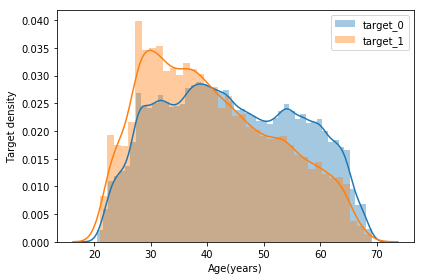

In [36]:
# 年齢構成のヒストグラムを作成
target_0 = X_train["DAYS_BIRTH"][X_train["TARGET"]==0]
target_1 = X_train["DAYS_BIRTH"][X_train["TARGET"]==1]
sns.distplot(target_0/365)
sns.distplot(target_1/365)
plt.xlabel("Age(years)")
plt.ylabel("Target density")
plt.legend(["target_0","target_1"], loc="best")
plt.tight_layout()
plt.show()

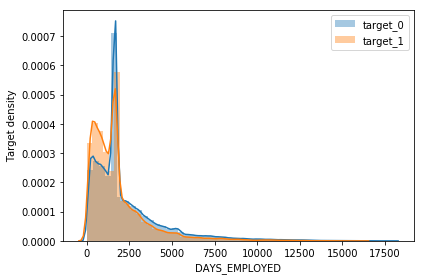

In [37]:
# "DAYS_EMPLOYED"のヒストグラムを作成
target_0 = X_train["DAYS_EMPLOYED"][X_train["TARGET"]==0]
target_1 = X_train["DAYS_EMPLOYED"][X_train["TARGET"]==1]
sns.distplot(target_0)
sns.distplot(target_1)
plt.xlabel("DAYS_EMPLOYED")
plt.ylabel("Target density")
plt.legend(["target_0","target_1"], loc="best")
plt.tight_layout()
plt.show()

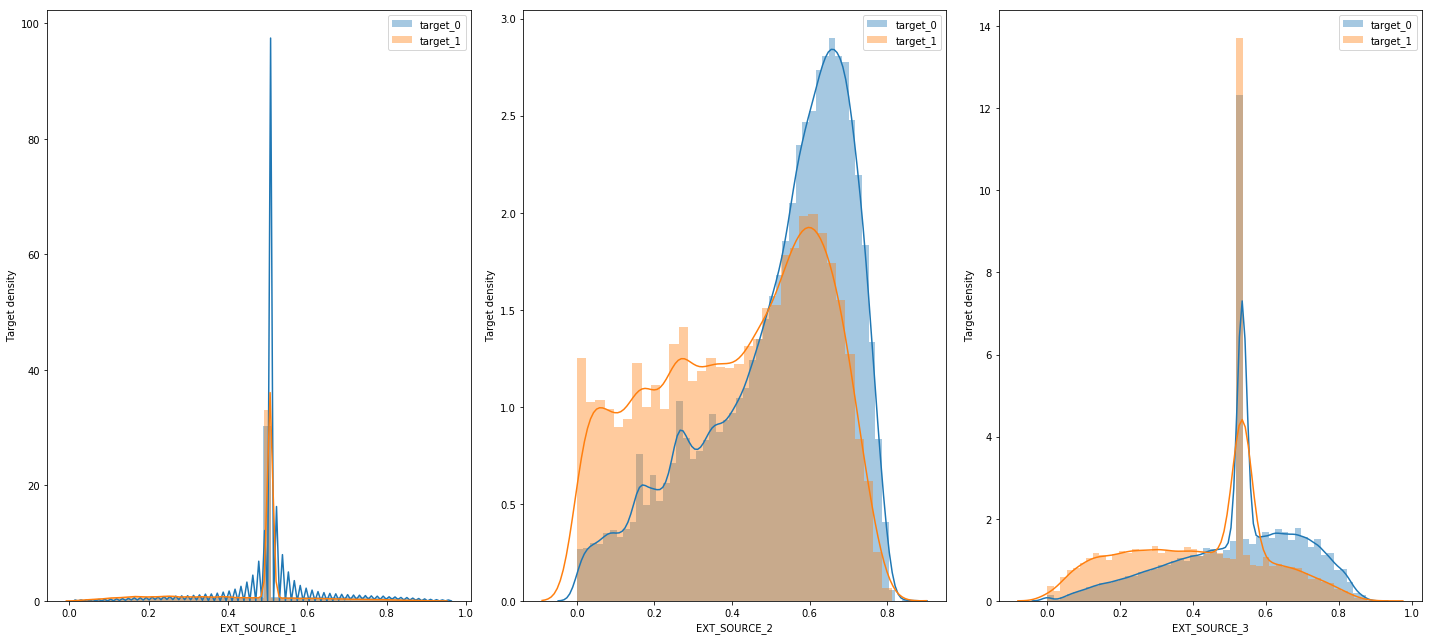

In [38]:
# EXT_SOURCEのヒストグラムを作成
fig, ax = plt.subplots(1, 3, figsize=(20,9))
for i in range(3):
    plt.subplot(1,3,i+1)
    target_0 = df_train["EXT_SOURCE_"+str(i+1)][df_train["TARGET"]==0]
    target_1 = df_train["EXT_SOURCE_"+str(i+1)][df_train["TARGET"]==1]
    sns.distplot(target_0)
    sns.distplot(target_1)
    plt.xlabel("EXT_SOURCE_"+str(i+1))
    plt.ylabel("Target density")
    plt.legend(["target_0","target_1"], loc="best")
plt.tight_layout()
plt.show()

In [39]:
# 相関行列とヒートマップを作成
X_train_corrs = X_train.corr()
X_train_corrs

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.078239,-0.063368,-0.098887,-0.160295,-0.155892
DAYS_BIRTH,-0.078239,1.000000,0.183299,0.362185,0.091947,0.178527
DAYS_EMPLOYED,-0.063368,0.183299,1.000000,0.131939,0.085817,0.087850
EXT_SOURCE_1,-0.098887,0.362185,0.131939,1.000000,0.134993,0.109100
EXT_SOURCE_2,-0.160295,0.091947,0.085817,0.134993,1.000000,0.094147
EXT_SOURCE_3,-0.155892,0.178527,0.087850,0.109100,0.094147,1.000000


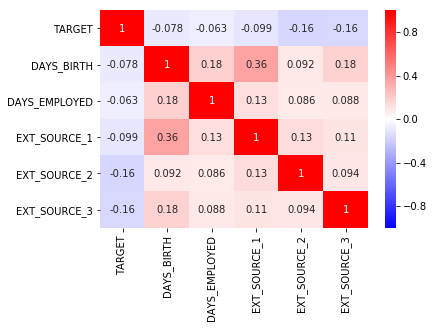

In [40]:
sns.heatmap(X_train_corrs, cmap="bwr", vmin=-1, annot=True)
plt.show()

In [0]:
y_train = X_train["TARGET"]
X_train = X_train[["DAYS_BIRTH","DAYS_EMPLOYED","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]]
X_test = X_test[["DAYS_BIRTH","DAYS_EMPLOYED","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]]


In [42]:
# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

# 訓練データのランダムフォレストで重要度を算出
rfc = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)
rfc.fit(X_train_scaled, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
rfc.feature_importances_

array([0.03033862, 0.08356568, 0.09035896, 0.38625026, 0.40948648])

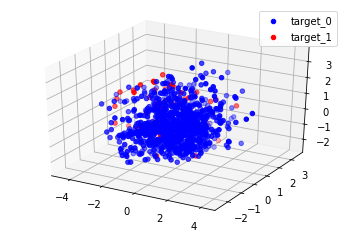

In [44]:
# 上記結果から、3つに特徴量削減
pca = PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# 訓練データの1000個のデータで3次元プロットしてみる
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
X1, X2, X3 = X_train_reduced[:,0][:1000], X_train_reduced[:,1][:1000], X_train_reduced[:,2][:1000]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X1[y_train[:1000]==0],X2[y_train[:1000]==0],X3[y_train[:1000]==0], 
           color="blue", label="target_0")
ax.scatter(X1[y_train[:1000]==1],X2[y_train[:1000]==1],X3[y_train[:1000]==1], 
           color="red", label="target_1")
plt.legend(loc="best")
plt.show()

In [45]:
lr = LogisticRegression(penalty="l2", C=2)
lr.fit(X_train_reduced, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_train, lr.predict_proba(X_train_reduced)[:,1])
print("classifier_auc: {}".format(lr_auc))



classifier_auc: 0.7196258147965269


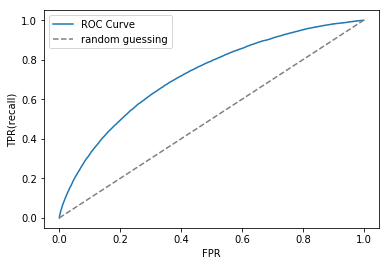

In [47]:
%matplotlib inline
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_reduced)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

In [48]:
# 交互作用特徴量を加えてみる
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_reduced)
X_train_poly = poly.transform(X_train_reduced)
X_test_poly = poly.transform(X_test_reduced)

print("X_train_poly shape: ", X_train_poly.shape)
print("X_test_poly shape: ", X_test_poly.shape)

X_train_poly shape:  (307511, 19)
X_test_poly shape:  (48744, 19)


In [49]:
# 新たな特徴量を加えた内訳
poly.get_feature_names()

['x0',
 'x1',
 'x2',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3']

In [50]:
lr = LogisticRegression(penalty="l2", C=2)
lr.fit(X_train_poly, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
# auc算出
lr_auc = roc_auc_score(y_train, lr.predict_proba(X_train_poly)[:,1])
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7220658082305391


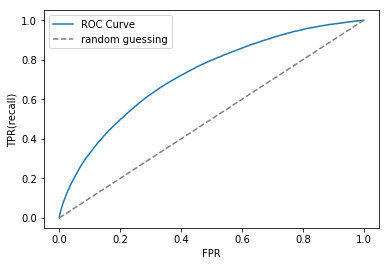

In [52]:
# ROC curve描画
fpr, tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_poly)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

わずかだが、aucが上昇したので、グリッドサーチと交差検証をしてみる

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(solver="lbfgs"))])
param_grid = {"lr__C": [0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train_poly, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
print("Best cross-val accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best cross-val accuracy: 0.92
Best parameters: {'lr__C': 0.1}


In [0]:
y_test_pred = grid.predict_proba(X_test_poly)[:,1]

In [56]:
df_submission = df_test[["SK_ID_CURR"]]
df_submission["TARGET"] = y_test_pred
df_submission.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.047861
1,100005,0.094533
2,100013,0.023523
3,100028,0.062327
4,100038,0.115285


In [0]:
# 検証結果をcsvファイルに保存
df_submission.to_csv("home_credit_submission.csv", index=False)

Kaggle提出結果： 0.71525

## Term1 Sprint1はここから

既存の特徴量を組み合わせて新たな特徴量を生成してみる。  
[Start Here: A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction "Start Here: A Gentle Introduction")

In [0]:
# 新たな特徴量生成に必要な特徴量列を選択
df_train_domain = df_train.copy()
df_train_domain = df_train_domain[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_EMPLOYED','DAYS_BIRTH']]
df_test_domain = df_test.copy()
df_test_domain = df_test_domain[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_EMPLOYED','DAYS_BIRTH']]


In [59]:
# 欠損値を確認
df_train_domain.isnull().sum()+df_test_domain.isnull().sum()

AMT_INCOME_TOTAL     0
AMT_CREDIT           0
AMT_ANNUITY         36
DAYS_EMPLOYED        0
DAYS_BIRTH           0
dtype: int64

In [0]:
# 中央値でfillna
df_train_domain['AMT_ANNUITY'] = df_train_domain['AMT_ANNUITY'].fillna(df_train_domain['AMT_ANNUITY'].median())
df_test_domain['AMT_ANNUITY'] = df_test_domain['AMT_ANNUITY'].fillna(df_test_domain['AMT_ANNUITY'].median())

信用情報自体の情報に基づき、新たな特徴量を生成してみる。  

['CREDIT_INCOME_PERCENT'] = ['AMT_CREDIT'] / ['AMT_INCOME_TOTAL']  
['ANNUITY_INCOME_PERCENT'] = ['AMT_ANNUITY'] / ['AMT_INCOME_TOTAL']  
['CREDIT_TERM'] = ['AMT_ANNUITY'] / ['AMT_CREDIT']  
['DAYS_EMPLOYED_PERCENT'] = ['DAYS_EMPLOYED'] / ['DAYS_BIRTH']  

In [0]:
df_train_domain['CREDIT_INCOME_PERCENT'] = df_train_domain['AMT_CREDIT'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['ANNUITY_INCOME_PERCENT'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['CREDIT_TERM'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_CREDIT']
df_train_domain['DAYS_EMPLOYED_PERCENT'] = df_train_domain['DAYS_EMPLOYED'] / df_train_domain['DAYS_BIRTH']

df_test_domain['CREDIT_INCOME_PERCENT'] = df_test_domain['AMT_CREDIT'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['ANNUITY_INCOME_PERCENT'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['CREDIT_TERM'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_CREDIT']
df_test_domain['DAYS_EMPLOYED_PERCENT'] = df_test_domain['DAYS_EMPLOYED'] / df_test_domain['DAYS_BIRTH']

In [0]:
df_train_domain = df_train_domain[['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']]
df_test_domain = df_test_domain[['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']]

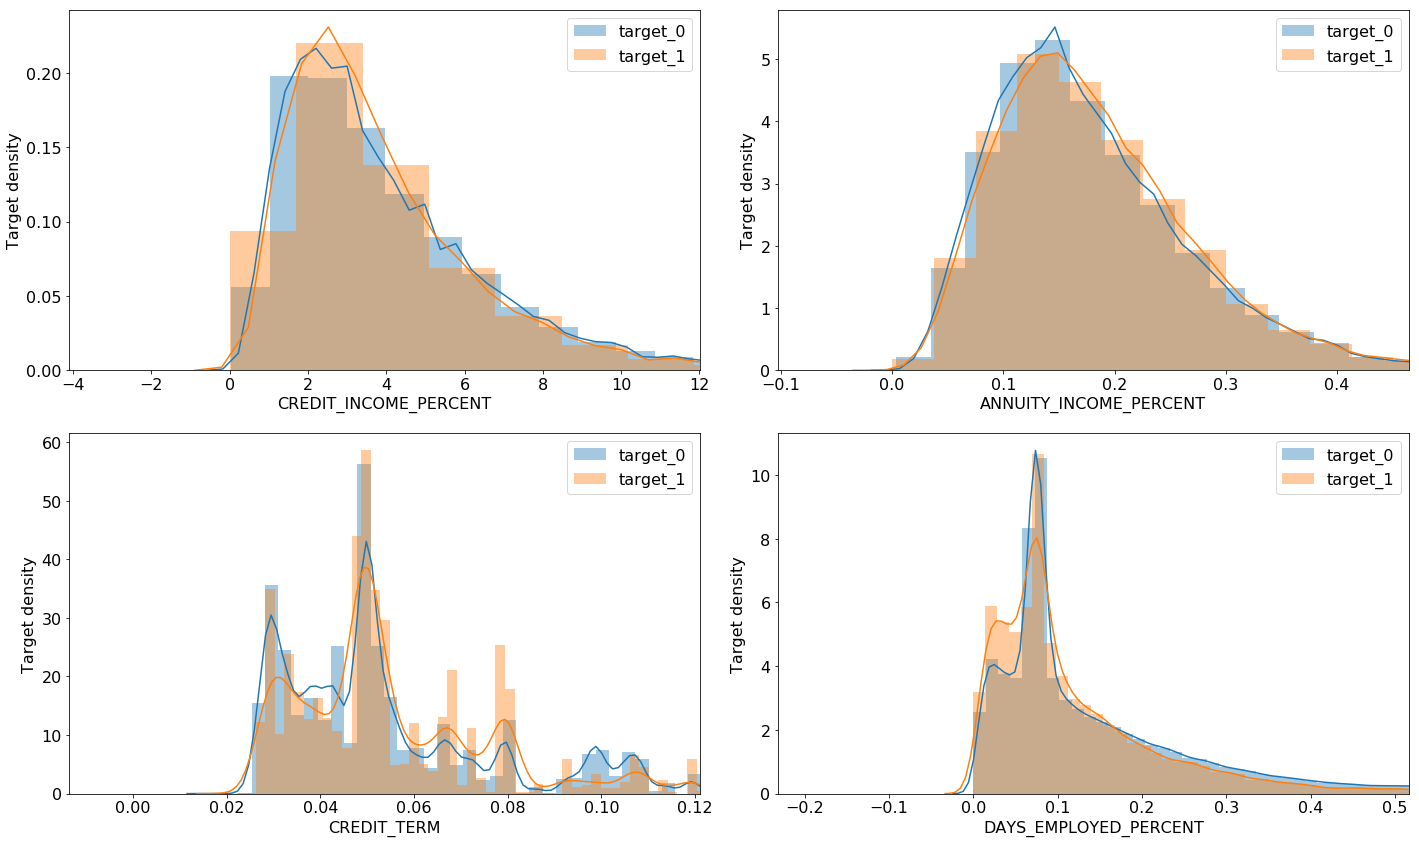

In [63]:
# 新特徴量のヒストグラムを作成
fig, ax = plt.subplots(2,2,figsize=(20,12))
plt.rcParams["font.size"]=16
for i, column in enumerate(df_train_domain.columns):
    target_0 = df_train_domain[column][y_train==0]
    target_1 = df_train_domain[column][y_train==1]
    plt.subplot(2,2,i+1)
    sns.distplot(target_0)
    sns.distplot(target_1)
    mean = df_train_domain[column].mean()
    std = df_train_domain[column].std()
    plt.xlim(mean - 3*std, mean + 3*std)
    plt.xlabel(column)
    plt.ylabel("Target density")
    plt.legend(["target_0","target_1"], loc="best")
plt.tight_layout()
plt.show()

In [0]:
# 新特徴量をX_trainとX_testに結合
X_train = pd.concat((X_train, df_train_domain), axis=1)
X_test = pd.concat((X_test, df_test_domain), axis=1)

In [65]:
X_train

,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,9461,637.0,0.083037,0.262949,0.139376,2.007889,0.121978,0.060749,0.067329
1,16765,1188.0,0.311267,0.622246,0.535276,4.790750,0.132217,0.027598,0.070862
2,19046,225.0,0.505998,0.555912,0.729567,2.000000,0.100000,0.050000,0.011814
3,19005,3039.0,0.505998,0.650442,0.535276,2.316167,0.219900,0.094941,0.159905
4,19932,3038.0,0.505998,0.322738,0.535276,4.222222,0.179963,0.042623,0.152418
5,16941,1588.0,0.505998,0.354225,0.621226,4.954500,0.277955,0.056101,0.093737
6,13778,3130.0,0.774761,0.724000,0.492060,9.127053,0.241526,0.026463,0.227174
7,18850,449.0,0.505998,0.714279,0.540654,4.250000,0.116875,0.027500,0.023820
8,20099,1648.0,0.587334,0.205747,0.751724,9.063200,0.300680,0.033176,0.081994
9,14469,2019.0,0.505998,0.746644,0.535276,3.000000,0.150000,0.050000,0.139540


In [66]:
# 相関係数行列を作成
X_train_corr = pd.concat((y_train, X_train), axis=1).corr()
X_train_corr

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
TARGET,1.000000,-0.078239,-0.063368,-0.098887,-0.160295,-0.155892,-0.007727,0.014268,0.012698,-0.049603
DAYS_BIRTH,-0.078239,1.000000,0.183299,0.362185,0.091947,0.178527,0.121975,0.081488,-0.092093,-0.057987
DAYS_EMPLOYED,-0.063368,0.183299,1.000000,0.131939,0.085817,0.087850,0.050989,0.010169,-0.065328,0.949090
EXT_SOURCE_1,-0.098887,0.362185,0.131939,1.000000,0.134993,0.109100,0.074727,0.034351,-0.076442,0.045623
EXT_SOURCE_2,-0.160295,0.091947,0.085817,0.134993,1.000000,0.094147,0.003237,-0.035492,-0.045754,0.067291
EXT_SOURCE_3,-0.155892,0.178527,0.087850,0.109100,0.094147,1.000000,0.084029,0.094253,0.002249,0.051630
CREDIT_INCOME_PERCENT,-0.007727,0.121975,0.050989,0.074727,0.003237,0.084029,1.000000,0.788104,-0.522141,0.024664
ANNUITY_INCOME_PERCENT,0.014268,0.081488,0.010169,0.034351,-0.035492,0.094253,0.788104,1.000000,-0.029694,-0.005362
CREDIT_TERM,0.012698,-0.092093,-0.065328,-0.076442,-0.045754,0.002249,-0.522141,-0.029694,1.000000,-0.041795
DAYS_EMPLOYED_PERCENT,-0.049603,-0.057987,0.949090,0.045623,0.067291,0.051630,0.024664,-0.005362,-0.041795,1.000000


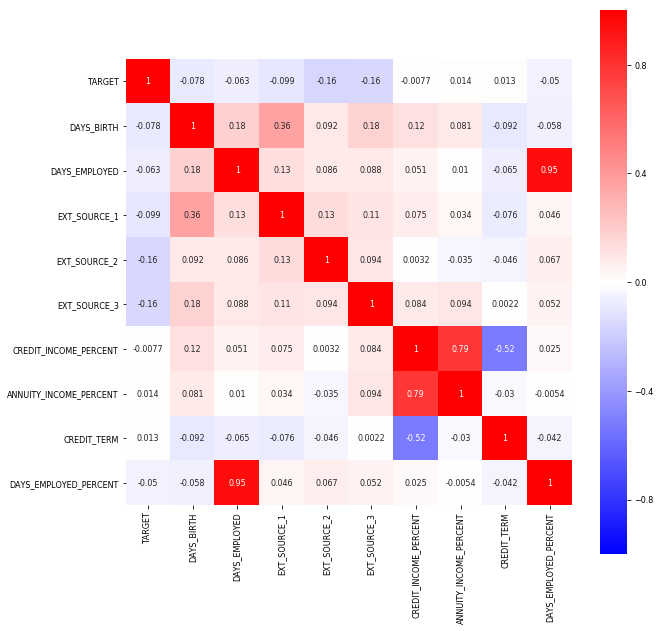

In [67]:
# 目的変数との相関を見る
plt.rcParams["font.size"]=8
plt.figure(figsize=(10,10))
sns.heatmap(X_train_corr, cmap="bwr", vmin=-1, annot=True, square=True)
plt.show()

In [0]:
# 上記より、"DAYS_EMPLOYED"は極めて相関が高いので消しておく
X_train = X_train.drop("DAYS_EMPLOYED", axis=1).astype("float64")
X_test = X_test.drop("DAYS_EMPLOYED", axis=1).astype("float64")

In [69]:
# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

# 訓練データのランダムフォレストで重要度を算出
rfc = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)
rfc.fit(X_train_scaled, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [70]:
rfc.feature_importances_

array([0.06897088, 0.07361887, 0.31149466, 0.45673016, 0.00374136,
       0.01252695, 0.04106274, 0.03185439])

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(solver="lbfgs"))])
param_grid = {"lr__C": [0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
print("Best cross-val accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best cross-val accuracy: 0.92
Best parameters: {'lr__C': 0.001}


In [73]:
# auc算出
lr_auc = roc_auc_score(y_train, grid.predict_proba(X_train)[:,1])
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7241917123906456


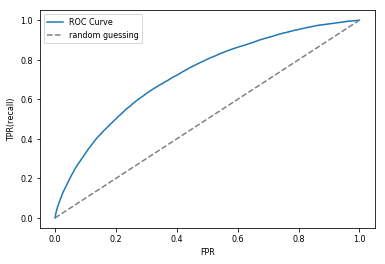

In [74]:
# ROC curve描画
fpr, tpr, thresholds = roc_curve(y_train, grid.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

In [0]:
y_test_pred = grid.predict_proba(X_test)[:,1]

In [76]:
df_submission = df_test[["SK_ID_CURR"]]
df_submission["TARGET"] = y_test_pred
df_submission.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.056442
1,100005,0.097940
2,100013,0.034923
3,100028,0.050559
4,100038,0.119676


In [0]:
# 検証結果をcsvファイルに保存
df_submission.to_csv("home_credit_submission.csv", index=False)

Kaggle提出結果： 0.71808

新たな４つの特徴量を加えた以下８つの特徴量群にて、今度は多項式特徴量を追加してみる  
['DAYS_BIRTH'], ['EXT_SOURCE_1'], ['EXT_SOURCE_2'], ['EXT_SOURCE_3'],  
['CREDIT_INCOME_PERCENT'], ['ANNUITY_INCOME_PERCENT'], ['CREDIT_TERM'], ['DAYS_EMPLOYED_PERCENT']

In [78]:
# 多項式特徴量を加えてみる
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print("X_train_poly shape: ", X_train_poly.shape)
print("X_test_poly shape: ", X_test_poly.shape)

X_train_poly shape:  (307511, 164)
X_test_poly shape:  (48744, 164)


In [79]:
# 新たな特徴量を加えた内訳
poly.get_feature_names()

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x6^2',
 'x6 x7',
 'x7^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0^2 x5',
 'x0^2 x6',
 'x0^2 x7',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x1 x5',
 'x0 x1 x6',
 'x0 x1 x7',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x2 x5',
 'x0 x2 x6',
 'x0 x2 x7',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x3 x5',
 'x0 x3 x6',
 'x0 x3 x7',
 'x0 x4^2',
 'x0 x4 x5',
 'x0 x4 x6',
 'x0 x4 x7',
 'x0 x5^2',
 'x0 x5 x6',
 'x0 x5 x7',
 'x0 x6^2',
 'x0 x6 x7',
 'x0 x7^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1^2 x5',
 'x1^2 x6',
 'x1^2 x7',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x2 x5',
 'x1 x2 x6

In [80]:
# 訓練データのランダムフォレストで重要度を算出
rfc = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)
rfc.fit(X_train_poly, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [81]:
rfc.feature_importances_

array([1.49698384e-04, 5.63059898e-03, 4.62404916e-03, 8.50597131e-03,
       6.31158677e-04, 4.13840730e-04, 5.18475710e-03, 0.00000000e+00,
       1.33635848e-03, 1.74011394e-03, 2.15495510e-02, 3.22909898e-02,
       0.00000000e+00, 7.98342589e-04, 0.00000000e+00, 1.30202838e-03,
       4.06133421e-04, 9.12002996e-03, 3.06635609e-02, 0.00000000e+00,
       0.00000000e+00, 1.05114176e-03, 5.32955790e-04, 1.47865757e-03,
       1.00922886e-01, 0.00000000e+00, 1.04780007e-02, 2.35440386e-03,
       5.22708909e-03, 2.79575331e-03, 0.00000000e+00, 0.00000000e+00,
       4.83865958e-04, 2.57189284e-03, 0.00000000e+00, 6.05820148e-04,
       3.97465818e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36571158e-03,
       0.00000000e+00, 4.82085852e-04, 5.77678121e-03, 6.52895425e-03,
       2.83571858e-04, 2.39146288e-03, 1.03333125e-03, 1.21384241e-03,
       9.24378543e-03, 1.18478362e-02, 1.55187633e-02, 6.76554419e-05,
      

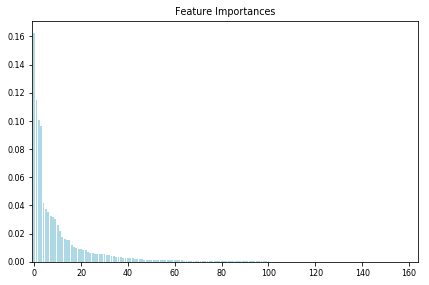

In [82]:
# 各特徴量の重要度の可視化
# 特徴量の重要度
ftr_imp = rfc.feature_importances_

# 特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(ftr_imp)),
             'feature': ftr_imp})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.number

# 特徴量の重要度順（降順）
indices = np.argsort(ftr_imp)[::-1]

plt.title('Feature Importances')
plt.bar(range(len(ftr_imp)),ftr_imp[indices], color='lightblue', align='center')
plt.xlim([-1, len(ftr_imp)])
plt.tight_layout()
plt.show()


In [0]:
# 上記結果から、40個に特徴量削減
pca = PCA(n_components=40)
pca.fit(X_train_poly)
X_train_reduced = pca.transform(X_train_poly)
X_test_reduced = pca.transform(X_test_poly)

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(solver="liblinear"))])
param_grid = {"lr__penalty":["l1","l2"], 
              "lr__C": [0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train_reduced, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__penalty': ['l1', 'l2'], 'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
print("Best cross-val accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best cross-val accuracy: 0.92
Best parameters: {'lr__C': 0.001, 'lr__penalty': 'l2'}


In [86]:
# auc算出
lr_auc = roc_auc_score(y_train, grid.predict_proba(X_train_reduced)[:,1])
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7296840113091791


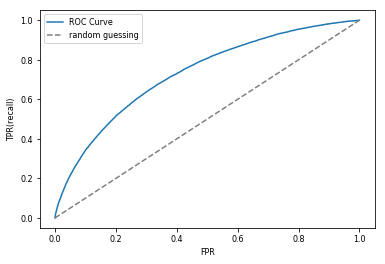

In [87]:
# ROC curve描画
fpr, tpr, thresholds = roc_curve(y_train, grid.predict_proba(X_train_reduced)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

In [0]:
y_test_pred = grid.predict_proba(X_test_reduced)[:,1]

In [89]:
df_submission = df_test[["SK_ID_CURR"]]
df_submission["TARGET"] = y_test_pred
df_submission.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.060608
1,100005,0.103935
2,100013,0.028642
3,100028,0.056426
4,100038,0.143821


In [0]:
# 検証結果をcsvファイルに保存
df_submission.to_csv("home_credit_submission.csv", index=False)

Kaggle提出結果： 0.72341

## 今日はここから

PCAによる40個への特徴量削減ではなく、単純に上位40個の特徴量選択だとどうなるか。

In [0]:
down_sort = np.argsort(ftr_imp)[::-1]
ftr_imp_sorted = ftr_imp[down_sort]

X_train_selected = X_train_poly[:, down_sort][:, :40]
X_test_selected = X_test_poly[:, down_sort][:, :40]

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(solver="liblinear"))])
param_grid = {"lr__penalty":["l2"], 
              "lr__C": [1,10,100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train_selected, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__penalty': ['l2'], 'lr__C': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [93]:
print("Best cross-val accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best cross-val accuracy: 0.92
Best parameters: {'lr__C': 1, 'lr__penalty': 'l2'}


In [94]:
# auc算出
lr_auc = roc_auc_score(y_train, grid.predict_proba(X_train_selected)[:,1])
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7280598469013966


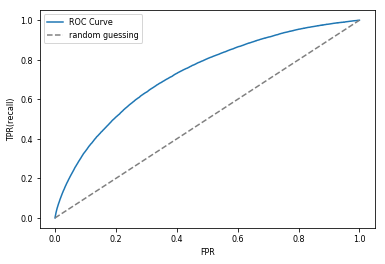

In [95]:
# ROC curve描画
fpr, tpr, thresholds = roc_curve(y_train, grid.predict_proba(X_train_selected)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

In [0]:
y_test_pred = grid.predict_proba(X_test_selected)[:,1]

In [97]:
df_submission = df_test[["SK_ID_CURR"]]
df_submission["TARGET"] = y_test_pred
df_submission.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.050773
1,100005,0.100953
2,100013,0.041418
3,100028,0.055420
4,100038,0.134772


In [0]:
# 検証結果をcsvファイルに保存
df_submission.to_csv("home_credit_submission.csv", index=False)

Kaggle提出結果： 0.71955

PCAによる特徴量削減のほうがAUCスコアが若干いいので、X_train_reducedで進める。これで他のモデルを試す。

In [101]:
from lightgbm import LGBMClassifier

pipe = Pipeline([("lgbmc", LGBMClassifier())])
param_grid = {"lgbmc__max_depth":[-1], 
              "lgbmc__num_leaves": [10,20,30]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train_reduced, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('lgbmc', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lgbmc__max_depth': [-1], 'lgbmc__num_leaves': [10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
print("Best cross-val accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best cross-val accuracy: 0.92
Best parameters: {'lgbmc__max_depth': -1, 'lgbmc__num_leaves': 20}


In [103]:
# auc算出
lr_auc = roc_auc_score(y_train, grid.predict_proba(X_train_reduced)[:,1])
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7607387214203178


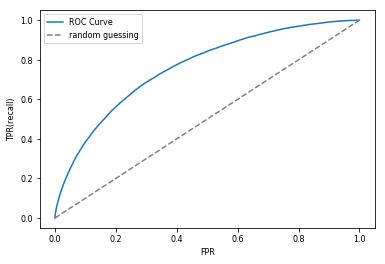

In [104]:
# ROC curve描画
fpr, tpr, thresholds = roc_curve(y_train, grid.predict_proba(X_train_reduced)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

In [105]:
y_test_pred = grid.predict_proba(X_test_reduced)[:,1]

df_submission = df_test[["SK_ID_CURR"]]
df_submission["TARGET"] = y_test_pred
df_submission.head()

# 検証結果をcsvファイルに保存
df_submission.to_csv("home_credit_submission.csv", index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Kaggle提出結果： 0.72921  
あまりにも学習が速いので全特徴量(164種類)で訓練してみる

In [112]:
pipe = Pipeline([("lgbmc", LGBMClassifier())])
param_grid = {"lgbmc__max_depth":[-1], "lgbmc__num_leaves": [10,20,30], 
             "lgbmc__class_weight":[None, "balanced"]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train_poly, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('lgbmc', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lgbmc__max_depth': [-1], 'lgbmc__num_leaves': [10, 20, 30], 'lgbmc__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
print("Best cross-val accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

Best cross-val accuracy: 0.92
Best parameters: {'lgbmc__class_weight': None, 'lgbmc__max_depth': -1, 'lgbmc__num_leaves': 20}


In [114]:
# auc算出
lr_auc = roc_auc_score(y_train, grid.predict_proba(X_train_poly)[:,1])
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7764146772609657


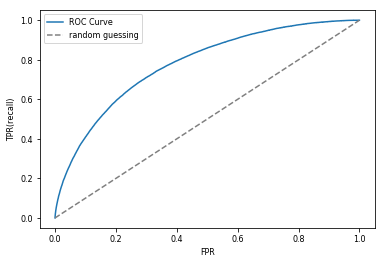

In [115]:
# ROC curve描画
fpr, tpr, thresholds = roc_curve(y_train, grid.predict_proba(X_train_poly)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")
plt.show()

In [110]:
y_test_pred = grid.predict_proba(X_test_poly)[:,1]

df_submission = df_test[["SK_ID_CURR"]]
df_submission["TARGET"] = y_test_pred
df_submission.head()

# 検証結果をcsvファイルに保存
df_submission.to_csv("home_credit_submission.csv", index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Kaggle提出結果： 0.74444

In [121]:
ft_imps = grid.best_estimator_.named_steps["lgbmc"].feature_importances_
ft_imps

array([ 41,  66,  21,  40,   6,   6, 311,   8,   0,   8,  12,  16,   2,
        17,  10,   9,   0,  12,  14,   4,   2,  25,   5,   0,  12,   3,
         2,  10,   7,   0,   7,   3,  18,  15,   0,   1,   0,   4,   0,
        10,   5,   0,   5,   0,   0,  15,  20,   8,   8,  27,  27,  26,
        41,  16,  25,   4,  11,  10,   4,  10,  12,   4,   8,   9,   6,
        19,   4,  11,   9,   9,   5,   6,   0,   5,   6,  16,  10,  15,
        10,   8,   0,  22,  25,  12,   7,  22,  10,  23,  67,   8,   5,
        16,  11,  19,   7,   4,   8,  17,  10,   1,   0,   7,   4,   8,
         7,  15,  10,   2,   0,  18,   7,  10,   8,   9,  21,  11,   9,
        15,  18,   5,   8,   0,   6,   6,   8,   7,  10,  10,   5,   0,
        12,   3,  18,  12,   4,   9,   0,   8,   9,  10,   9,  13,   7,
         6,   0,   5,   0,   6,   6,   0,   6,   0,   0,   4,   0,   8,
         6,  12,   9,   3,   0,   4,  12,   0])

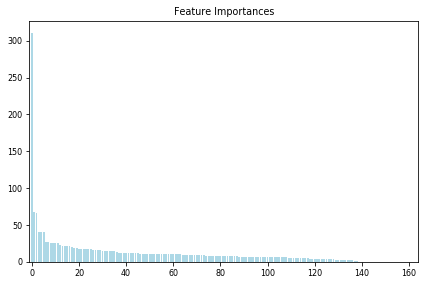

In [122]:
# 各特徴量の重要度の可視化
# 特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(ft_imps)),
             'feature': ft_imps})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.number

# 特徴量の重要度順（降順）
indices = np.argsort(ft_imps)[::-1]

plt.title('Feature Importances')
plt.bar(range(len(ft_imps)),ft_imps[indices], color='lightblue', align='center')
plt.xlim([-1, len(ft_imps)])
plt.tight_layout()
plt.show()


In [124]:
indices

array([  6,  88,   1,   0,  52,   3,  49,  50,  51,  21,  54,  82,  87,
        85,  81,   2, 114,  46,  65,  93, 109,  32, 132, 118,  97,  13,
        53,  11,  75,  91, 117,  45,  33, 105,  77,  18, 141,  83, 162,
        10,  24, 157,  17, 133, 130,  60,  67,  56, 115,  92,  59,  39,
       106,  27,  14, 139, 111,  86, 127,  57,  78,  76, 126,  98,  69,
        68,  63, 116, 140, 138, 135,  15, 158, 113,  96,   7, 137,   9,
       155, 124, 120,  79,  48, 112, 103,  62,  89,  47, 110, 125,  84,
       104,  30,  28, 101, 142,  94, 156,   5,   4, 148,  74, 122, 143,
       150,  71, 123,  64, 147,  40,  42, 145,  90, 128,  22,  70, 119,
        73, 102,  95,  37, 134,  19,  61, 153,  66,  58,  55, 161, 159,
       131,  31,  25,  12,  20, 107,  26,  35,  99, 136, 146,   8, 129,
       160, 144,  16, 100, 121,  44,  72, 154,  80, 152, 151, 149,  43,
        23,  41,  38,  36,  34,  29, 108, 163])

6番目の新特徴量（"CREDIT TERM"）が最もFeature importancesが高い

以下のアクションで更にスコアが上がるかもしれない。
- 既存の特徴量をもっと加える
- 新特徴量から新新特徴量を作る（相関が高いものは削除）
- モデルチューニングをもっと凝る
- 別のモデルを試す
- 欠損値の埋め合わせ値を工夫する